In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Section 1 - The spelled out intro to NN + Backpropagation 

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

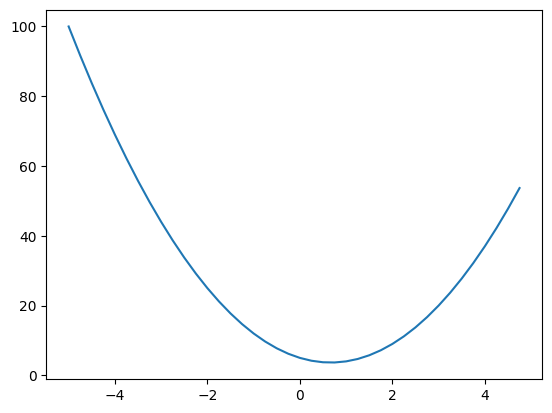

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# Derivative Definition 

h = 0.001
x = -3.0
(f(x+h) - f(x))/h


-21.996999999998934

In [6]:
# a = 2.0
# b= -3.0 
# c= 10.0
# d = a*b +c

# print(d)

##### NOTES
- Partial derivatives play a crucial role in backpropagation by enabling the calculation of how each weight influences the final loss.
- The chain rule from calculus is used recursively to determine the partial derivative of the loss with respect to each weight.
##### For the Example Below

- A simple expression such as `d = a * b + c` is used to demonstrate how changing one input variable (e.g., 'a') affects the output ('d').
- By slightly increasing 'a' and observing the change in 'd', the video numerically approximates the partial derivative of 'd' with respect to 'a'.
- This process is repeated for 'b' and 'c' to highlight how each input variable's change uniquely impacts the output.

In [7]:
# h = 0.0001

# # inputs 
# a = 2.0
# b= -3.0 
# c= 10.0


# d1 = a*b +c
# a += h
# d2 = a*b +c

# print('d1', d1)
# print('d2', d2)
# print('slope', (d2-d1)/h)

In [8]:
# class Value:
#     def __init__(self, data):
#         self.data = data
    
#     # __repr__ helps with returning non-cryptic information about the objects you are creating
#     def __repr__(self) -> str:
#         return f"Value(data={self.data})"
    
    
# a = Value(2.9)

In [9]:
# class Value:
#     def __init__(self, data):
#         self.data = data
    
#     def __repr__(self) -> str:
#         return f"Value(data={self.data})"
    
#     def __add__(self,other):
#         out = Value(self.data + other.data)
#         return out
    
# a = Value(2.0)
# b = Value(-3.0)
# a+b+b

In [10]:
# class Value:
#     def __init__(self, data):
#         self.data = data
    
#     def __repr__(self) -> str:
#         return f"Value(data={self.data})"
    
#     def __add__(self,other):
#         out = Value(self.data + other.data)
#         return out 
    
#     def __mul__(self,other):
#         out = Value(self.data * other.data)
#         return out
    
# a = Value(2.0)
# b = Value(-3.0)
# c = Value(-3.0)
# a*b + c 

### Understanding Backpropagation

The sources explain backpropagation as a fundamental algorithm in training artificial neural networks. It enables a neural network to learn from data and improve its accuracy by efficiently calculating how changes in the network's weights impact its output.

**At its core, backpropagation is an application of the chain rule from calculus.** The chain rule helps calculate the derivative of a composite function, where one function's output becomes the input of another. _In neural networks, this means determining how a change in one weight affects the final output (usually measured as a loss)._

**Here's a step-by-step breakdown of backpropagation:**

1. **Forward Pass:** The input data is fed through the network, with each neuron performing calculations involving weighted sums and activation functions. This process generates an output, which is then compared to the desired target output to calculate a loss value. 

2. **Loss Calculation:** The loss function quantifies how "off" the network's prediction is from the actual target.  Common loss functions include mean squared error and cross-entropy loss.

3. **Backpropagation:** This is where the chain rule comes into play. Starting from the output layer, backpropagation traverses the network in reverse, calculating the gradient of the loss with respect to each weight.  
    * **Local Gradients:** At each node (neuron or operation), a local gradient is calculated, representing the immediate impact of changes to that node's inputs on its output. For example, in a multiplication node (`e = a * b`), the local gradient of 'e' with respect to 'a' is simply 'b'.
    * **Chaining Gradients:** These local gradients are then multiplied with the gradients from subsequent layers (obtained during the backward pass) to determine the gradient of the loss with respect to each weight in the network. This is the essence of the chain rule's application.

4. **Gradient Accumulation:** It's crucial to correctly accumulate gradients, particularly when a variable is used multiple times in the network. This ensures that the final gradient reflects the combined influence of that variable on the loss.

5. **Weight Update:** Once the gradients for all weights are calculated, an optimization algorithm, such as gradient descent, uses this information to adjust the weights. The weights are updated in a direction that reduces the loss, effectively making the network's predictions more accurate.

6. **Zeroing Gradients:** Before the next iteration of training, it's essential to reset the `grad` values to zero for all parameters (weights). This prevents the accumulation of gradients from previous iterations, which can lead to incorrect weight updates and instability during training. 

**The sources emphasize this last step as a common, yet critical, bug in implementing backpropagation.** Modern deep learning libraries, like PyTorch, often provide functions like `zero_grad()` to streamline this process.

**The process of backpropagation is iterative.** By repeatedly performing forward passes, backpropagating gradients, and updating weights, the network progressively learns to minimize the loss, resulting in more accurate predictions.

The sources use both simplified examples (e.g., `d = a * b + c`) and more complex scenarios involving neurons and MLPs to illustrate the mechanics of backpropagation and how the chain rule enables efficient gradient calculation. They highlight that while the complexity of the network may increase, the underlying principles of backpropagation remain the same.





In [11]:
# How to create a trace of operations that results in a certain value 

class Value:
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        # _children: tuple -> set for efficiency
        self._prev = set(_children)
        # grad/gradient: how much it effects the loss funtion. Set to be 0; however, you need to update it to be 1 for your output node. 
        self.grad = 0.0
        self._op = _op
        self.label = label
        self._backward = lambda: None
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        # bug note:  
        #### += instead of just + to avoid overwriting when  a variable is being used more than once
        #### also the gradients add up when they are being used more than once
        def _backward():
                self.grad += 1.0 * out.grad
                other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out 
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
            out._backward = _backward
        
        return out 
    
    def backward(self):
        # this funtion sets up topological sort to make sure that backpropogation is done in its proper order authomatically. 
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        # initialize the node
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    
a = Value(2.0); a.label='a'
b = Value(-3.0); b.label='b'
c = Value(10.0); c.label='c'
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0); f.label='f'
L = d * f; L.label = 'L'

print(L._prev)
print(L._op)

{Value(data=-2.0), Value(data=4.0)}
*


In [12]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

### Chain Rule and Multiplication in Backpropagation

The sources provide a detailed explanation of the chain rule and its application in backpropagation, particularly highlighting the role of multiplication in calculating derivatives. The chain rule essentially describes how to compute the derivative of a composite function. In the context of neural networks, this translates to understanding how changes in one variable propagate and affect the final output (loss) through a series of interconnected operations.

#### The Chain Rule Explained

The chain rule states that if a variable 'z' depends on 'y', which in turn depends on 'x', then the derivative of 'z' with respect to 'x' can be calculated by multiplying the derivative of 'z' with respect to 'y' with the derivative of 'y' with respect to 'x'. This can be represented as:

```
dz/dx = (dz/dy) * (dy/dx)
```

The sources use a car, bicycle, and walking man analogy to illustrate this. If a car travels twice as fast as a bicycle, and the bicycle is four times faster than a walking man, then the car travels eight times faster than the man (2 * 4 = 8). This analogy demonstrates the multiplicative nature of chained rates of change.

#### Impact of Multiplication on Derivatives

The sources showcase the impact of multiplication on derivatives through the example of a simple multiplication node in a computation graph.  Consider `e = a * b`. The chain rule dictates that to calculate the derivative of the final output 'l' (loss) with respect to 'a' (`dl/da`), we need to consider the influence of 'a' on 'e' (`de/da`) and the influence of 'e' on 'l' (`dl/de`).

* **Local Derivative:** The local derivative `de/da` represents the immediate impact of 'a' on 'e', which is simply the value of 'b'.
* **Chaining the Derivative:** To obtain `dl/da`, we multiply the local derivative (`de/da` or 'b') with the derivative of the loss with respect to 'e' (`dl/de`), effectively chaining the impact of 'a' through 'e' to the final loss.

Therefore, the multiplication operation within the expression directly influences the derivative calculations through its presence in the local derivative. The value of 'b' acts as a scaling factor for the backpropagated gradient.

#### Generalization to Neural Networks

This principle extends to neural networks where multiple interconnected neurons, each performing operations like multiplication and addition, contribute to the final loss. During backpropagation, the chain rule is applied recursively to determine the partial derivative of the loss with respect to each weight in the network. These partial derivatives inform how each weight should be adjusted to minimize the loss.

#### Key Takeaways

* The chain rule enables the efficient calculation of gradients in complex, nested expressions like neural networks.
* Multiplication operations within these expressions directly impact the calculation of derivatives by contributing to local gradients.
* By understanding the chain rule and the influence of different operations on derivatives, you can gain deeper insights into how backpropagation works and how neural networks are trained. 


# Partial Derivatives + Chain Rule

local node -> d = c + e
dd/dc = 1 
dd/de = 1 

WANT: 
    - dL / dc : question: how does `c` impact the outcome of L
        - (dL / dd) * (dd/ dc)
    
KNOW: 
    - dL / dd : the rate of change for L when d changes
    - dd / dc : the rate of change for d when c changes

In [13]:
# dL
d.grad = -2.0
f.grad = 4.0

# dd * CHAIN 

c.grad = 1.0 * d.grad
e.grad = 1  * d.grad

# de * CHAIN

a.grad = -3.0 * e.grad
b.grad = 2 * e.grad

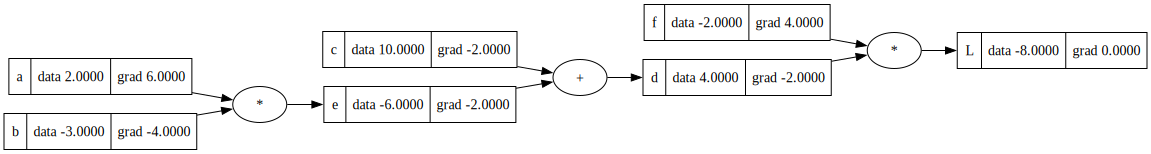

In [14]:
draw_dot(L)

In [15]:
def lol():
    h=0.0001
    a = Value(2.0, label= 'a')
    b = Value(-3.0, label= 'b')
    c = Value(10.0, label= 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    

    a = Value(2.0 + h, label= 'a')
    b = Value(-3.0, label= 'b')
    c = Value(10.0, label= 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2-L1)/h)
    
lol()

6.000000000021544


In [16]:
# gradients are key for us to understand how we want to influence the final outcome
# you have control over the leaf notes more 

# "one step of optimazion"
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# forward pass 
e = a * b
d = e + c
L = d * f

print(L.data)

# every time you run this cell, your "L" will get updated and it will get slighly larger -- step optimzation 


-7.286496


![CS231nNeuronModel.jpeg](./CS231nNeuronModel.jpeg)

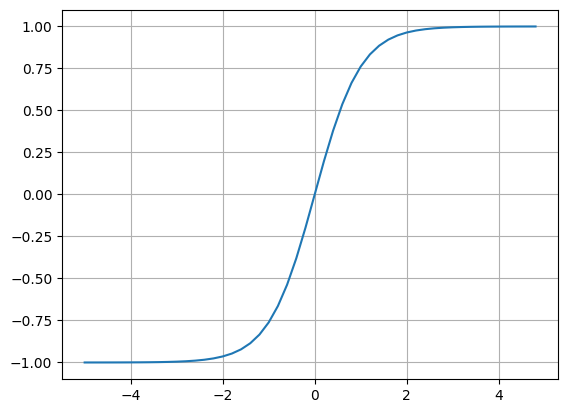

In [17]:
# tanh function

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [18]:
# inputs x1,x2 (2-d neuron)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2 (synaptic stregth for each input -- how much I care about a given input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron 
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

draw_dot(n)
# output layer funtion
o = n.tanh(); o.label = 'o'


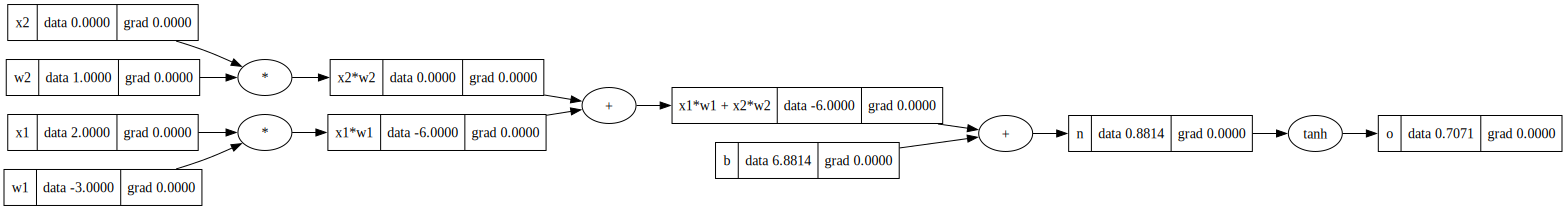

In [19]:
draw_dot(o)

In [20]:
#start of backpropogation (Automated for all nodes)

o.backward()

In [21]:
#start of backpropogation (Semi-Manual)

# this initiallizes the derivative for the output funtion 
o.grad = 1.0

o._backward()
n._backward()
# b is a leaf node so no need to _backward. However, we set up the initialization in a way that it just sets it up to be none
b._backward()

x1w1x2w2._backward()

x1w1._backward()

x2w2._backward()

In [22]:
#start of backpropogation (Manual)

o.grad = 1.0

# o = tanh(n)
# do/dn = 1 - tanh(n)**2  OR 1 - o**2 

# Step1: do/dn

n.grad = 1 - o.data**2

# Step2: do/ d(x1w1x2w2) and do/ db
# + is a distributure of gradient

x1w1x2w2.grad = 1.0 * n.grad
b.grad = 1.0 * n.grad

# Step3: do/d(x1w1) and do/d(x2w2)

x1w1.grad = 1.0 * x1w1x2w2.grad

x2w2.grad = 1.0 * x1w1x2w2.grad

# Step4.1: do/d(x1) and do/d(w1)

x1.grad = -3.0 * x1w1.grad
w1.grad = 2.0 * x1w1.grad


# Step4.2: do/d(x2) and do/d(w2)

x2.grad = 1.0 * x2w2.grad
w2.grad = 0 * x2w2.grad

# Learning: In this specific case, we can see that w1 will positively impact our `o` funtion and w2 has no impact on it.




In [23]:
import torch
import random

In [24]:
# NOTE: This implementation is only for demo to show that our implementation above.  
# .double() changes the default dtype from float32 to float64
# leaf nodes, in other words inputs, by default set to not require grad for efficiency reasons

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
# single neuron
n = x1*w1 + x2*w2 + b
# output layer
o = torch.tanh(n)

# .item() strips 

print(o.data.item())

# runs backpropogation
o.backward()

# returns leaf note gradients // compare with your output

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### Precision and Performance: Why PyTorch Defaults to `float32`

The sources do not explicitly discuss PyTorch's default use of `float32` (single-precision floating-point numbers) over `float64` (double-precision). However, based on general knowledge of deep learning and computer architecture, the choice primarily involves a trade-off between **precision** and **performance**:

* **Precision:** `float64` offers higher precision than `float32`, meaning it can represent numbers with greater accuracy. However, in the context of deep learning, the slight gain in precision offered by `float64` is often not crucial for achieving good model performance. 
* **Performance:** `float32` requires half the memory storage compared to `float64`. Using `float32` reduces the memory footprint of the model and its associated data, leading to faster data transfer and computation, especially when leveraging GPUs, which are often optimized for single-precision operations. 

**Why `float32` is Generally Sufficient for Deep Learning:**

* **Gradient-Based Optimization:** Deep learning models are trained using gradient-based optimization algorithms. These algorithms rely on calculating gradients, which represent the direction and magnitude of change needed to minimize the loss function.  Small inaccuracies in gradient calculations due to using `float32` generally do not hinder the optimization process. The optimization process is inherently noisy, and the gradients themselves are estimates.
* **Model Generalization:**  Deep learning models aim to generalize well to unseen data, and excessive precision can sometimes lead to overfitting, where the model memorizes the training data too closely and fails to perform well on new examples. 

**PyTorch's Flexibility:**

While PyTorch defaults to `float32`, it provides the flexibility to use `float64` (or other data types) if needed.  The sources demonstrate casting a tensor to `double` (which corresponds to `float64` in PyTorch) to ensure consistency with Python's default floating-point precision.

```python
import torch
tensor = torch.tensor(2.0).double() 
```

**Beyond the Sources:**

It's worth noting that the choice between `float32` and `float64` may depend on the specific application and hardware.  In some scientific computing or high-precision scenarios, `float64` might be preferred. However, for most deep learning tasks, `float32` strikes a good balance between precision and performance. 

**Key Takeaway:**

PyTorch's default choice of `float32` is motivated by performance considerations. The reduced memory footprint and faster computation outweigh the marginal gain in precision offered by `float64` in most deep learning scenarios.  


In [25]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

![image](./Neuron.jpeg)

### Understanding Multi-Layer Perceptrons (MLPs)

The sources primarily focus on building the foundational concepts of backpropagation and automatic differentiation, culminating in a basic implementation of a two-layer multi-layer perceptron (MLP) using the `micrograd` library. 

**What is an MLP?**

An MLP is a type of artificial neural network that consists of interconnected layers of **neurons**, also known as **perceptrons**.  It's a fundamental architecture in deep learning, serving as a building block for more complex networks.  

**Key Characteristics of MLPs:**

* **Layered Structure:** MLPs have at least three layers:
    * **Input Layer:** This layer receives the initial input data, where each neuron represents a feature or dimension of the input.
    * **Hidden Layers:**  MLPs can have one or more hidden layers, each containing multiple neurons. These layers perform intermediate computations and transformations on the data, allowing the network to learn complex patterns and relationships.
    * **Output Layer:** The final layer produces the network's predictions or outputs. The number of neurons in the output layer depends on the task, such as binary classification (one neuron), multi-class classification (one neuron per class), or regression (one neuron for continuous output).
* **Fully Connected Layers:** In a typical MLP, each neuron in a given layer is connected to *every* neuron in the subsequent layer. This full connectivity enables information to flow through the network in a dense manner.
* **Non-Linear Activation Functions:** Each neuron in the hidden and output layers applies a non-linear activation function to its input. Common activation functions include:
    * **Sigmoid:** Squashes the output between 0 and 1.
    * **Tanh (Hyperbolic Tangent):** Squashes the output between -1 and 1.
    * **ReLU (Rectified Linear Unit):** Outputs the input if positive, otherwise outputs 0.

**A Simple Neuron Model:**

The sources illustrate a basic mathematical model of a neuron, which forms the core computational unit within an MLP:

1. **Weighted Sum of Inputs:** The neuron calculates a weighted sum of its inputs. Each input is multiplied by a corresponding **weight**, representing the strength of the connection between that input and the neuron. A **bias** term is then added to this weighted sum. 

2. **Activation Function:** The weighted sum plus bias is passed through a non-linear activation function (e.g., tanh), producing the neuron's output.

**MLP as a Mathematical Expression:**

The sources emphasize that an MLP can be viewed as a complex mathematical expression. This expression takes the input data and the weights of the network as inputs and produces the network's output or predictions.  The weights and biases are the adjustable parameters of the network, which are learned during training to optimize performance.

**Training an MLP: Gradient Descent and Backpropagation**

The training process aims to find the optimal values for the network's weights and biases that minimize the **loss function**, a measure of how well the network is performing.  This optimization is typically achieved using **gradient descent**, an iterative algorithm that adjusts the parameters in the direction that reduces the loss.

**Backpropagation** is the key algorithm used to calculate the gradients of the loss function with respect to the network's weights and biases. It works by propagating the error signal back through the network, layer by layer, using the chain rule from calculus. This process allows the algorithm to determine how much each parameter contributes to the overall error and adjust them accordingly.

**Implementing an MLP in `micrograd`**

The sources walk through a step-by-step implementation of an MLP in `micrograd`, highlighting the following concepts:

1. **Building a Neuron:** Defining a `Neuron` class that encapsulates the forward pass of a single neuron (weighted sum of inputs, activation function).
2. **Creating a Layer:**  Creating a `Layer` class that represents a collection of neurons, all connected to the same inputs. 
3. **Constructing an MLP:**  Defining an `MLP` class that combines multiple layers sequentially, forming the complete network.
4. **Forward Pass:** Calculating the output of the network for a given input.
5. **Loss Calculation:**  Determining the error between the network's predictions and the target values using a chosen loss function (e.g., mean squared error).
6. **Backpropagation:** Calling the `.backward()` method on the loss to compute the gradients of the loss with respect to all the parameters in the network.
7. **Parameter Update:** Updating the values of the weights and biases using gradient descent, moving them in the direction that reduces the loss.
8. **Training Loop:** Iterating over the data, performing forward pass, backward pass, and parameter update repeatedly until the network achieves the desired performance.

**PyTorch's Equivalence**

The sources demonstrate that the same MLP structure and training process can be replicated using PyTorch, but with the added efficiency of tensor operations.  PyTorch's API provides ready-made modules for neurons (`torch.nn.Linear`) and activation functions, making it more streamlined for building and training neural networks. 

**Beyond MLPs**

While MLPs are fundamental, modern deep learning architectures have advanced beyond this basic structure. Convolutional neural networks (CNNs) are highly effective for image and sequence data, while recurrent neural networks (RNNs) excel at processing sequential data like text or time series. However, the core principles of gradient descent and backpropagation, as illustrated in the sources through MLPs, remain essential for training these more sophisticated networks.


In [26]:
# We are creating the NN representation above. 

# STEP 1: Build a Neuron

class Neuron:
  # nin in the contrctor describes that # of inputs
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
    
  # this funtion sets up the forward pass//inference for a single neuron 
  def __call__(self, x):
    # w * x + b
    # zip creates a tuple for each weight and input pairing (wi, xi)
    # then you create this for each item in your matric wi * xi
    # by using sum, you eventually create wi * xi + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]
  

In [27]:
# NOTE: In the video, Andrej implemented a line to the operator funtions to conver floats to Value. 
# That's why my implementation initially had errors. 

x = [2.0, 3.0]
n = Neuron(2)
n(x)


Value(data=-0.24339095280567968)

In [28]:
# STEP 2: Build a Layer of Neurons

class Layer:

# This class uses the Neuron class to create a layer -- see the code below
# nin -> # of inputs as before
# nout -> # of neurons in a layer
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]



In [29]:
x = [2.0, 3.0]
# Creating a 3-neuron layer that takes two inputs
n = Layer(2,3)
# The result shows "A"/output of each neuron
n(x)

[Value(data=-0.24700372274336574),
 Value(data=0.829432603446456),
 Value(data=0.4298450432473406)]

In [30]:
# STEP 3: Build an MPL

# This class uses the Neuron class to create a layer -- see the code below
# nin -> # of inputs as before
# nouts -> list of # of neurons in MPL 

class MLP:
  
  def __init__(self, nin, nouts):
    # add the input layer to nouts
    sz = [nin] + nouts
    # This makes sense because # of neurons is equal to # of # of outputs that would be fed in to the next layer. 
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [31]:
x_in = [2.0, 3.0, -1.0]
n_mlp = MLP(3, [4,4,1])
n_mlp(x_in)


Value(data=-0.9534272936142569)

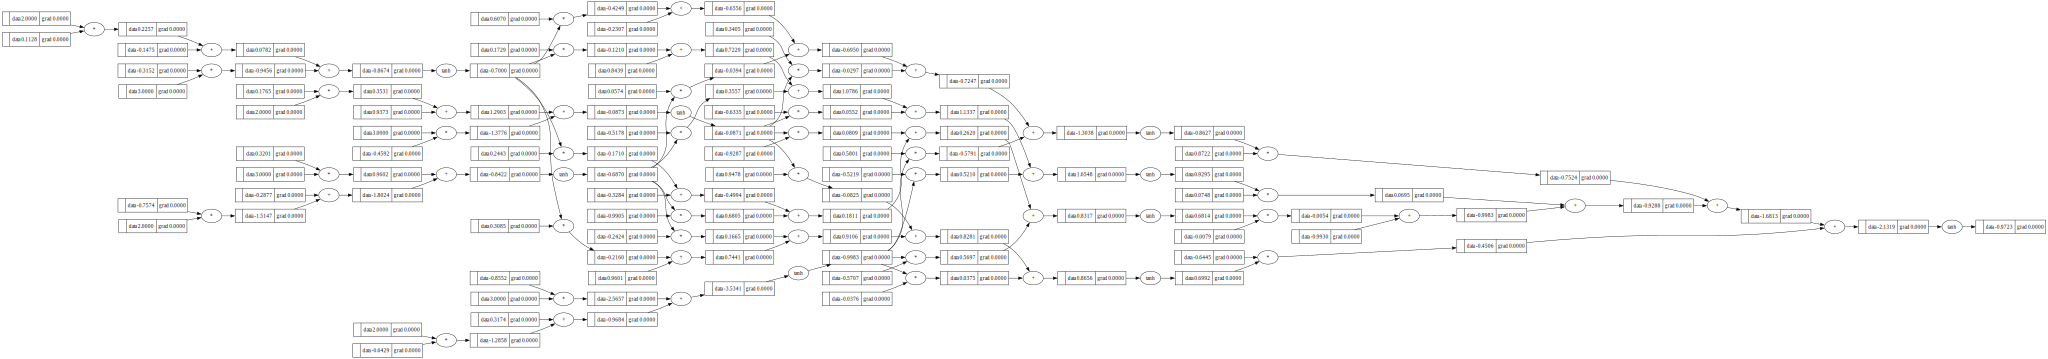

In [32]:
draw_dot(n_mlp(x))

In [33]:
# Example Neural Network

# xs defines 4 distinct examples m
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# ys defines the desired output for these 4 examples

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# ypred return the rediction using the neural net we created. Activation function of the output is tanh 
ypred = [n_mlp(x) for x in xs]

ypred

# sample result: [Value(data=-0.5253308604737081),
#                 Value(data=-0.480398317112605),
#                 Value(data=-0.4731716806084668),
#                 Value(data=-0.6068230035383054)] 
# The current results are not great with the weights that we have so in the next cell, 
# we will implement a loss funtion to figure out how we need to adjust the parameters 
# so that we can find the sweetspot

[Value(data=-0.9534272936142569),
 Value(data=-0.9059801454889943),
 Value(data=-0.9411051862021836),
 Value(data=-0.9687209291540664)]

In [34]:
# Implementing Mean Squared Error as the loss function
loss = [(y_out - y_ground)**2 for y_ground, y_out in zip(ys, ypred)]
cost = np.sum(loss)
cost

Value(data=7.704048620460921)

In [35]:
cost.backward()

In [45]:
# draw_dot(cost)


### Updating Parameters in `micrograd`: Implementing Gradient Descent

The sources walk through the process of building a basic neural network library called `micrograd`, culminating in the training of a two-layer multi-layer perceptron (MLP). The training process involves iteratively updating the network's parameters (weights and biases) to minimize the loss function, a measure of how well the network is performing.  This iterative update process is known as **gradient descent**.  You asked specifically about how the parameters are updated within a `for` loop.

**1. Gathering Parameters**

Before updating, you need to collect all the adjustable parameters within the neural network (the weights `w` and biases `b` of each neuron) into a single list.  The sources provide code to achieve this:

```python
def parameters(self):
    return [p for layer in self.layers for p in layer.parameters]
```

This code iterates through each layer in the MLP and then through each neuron within that layer, extracting the `parameters` of each neuron (which is a list containing the neuron's weights `w` and bias `b`) and appending them to a single list called `params`. 

**2. The Update Loop**

Once you have a list of all the parameters, you can proceed with the update process. The sources use a `for` loop to iterate through each parameter `p` in the `n.parameters` list:

```python
for p in n.parameters:
    p.data -= learning_rate * p.grad
```

Let's break down this update step:

* **`p.data`:** This refers to the actual numerical value of the parameter (either a weight or a bias).
* **`learning_rate`:** This is a hyperparameter that controls the size of the update step.  It's typically a small value (e.g., 0.01, 0.1) to avoid overshooting the optimal parameter values.
* **`p.grad`:** This represents the gradient of the loss function with respect to this specific parameter `p`. The gradient indicates the direction and magnitude of change needed in the parameter to reduce the loss.

**3. The Update Rule: Gradient Descent**

The core update rule in gradient descent is:

```
parameter = parameter - learning_rate * gradient
```

This rule essentially states that you should adjust each parameter in the *opposite* direction of its gradient.  The negative sign is crucial because the gradient points in the direction of *increasing* the loss, while you want to *minimize* the loss.  The `learning_rate` scales the magnitude of the update, determining how much you move the parameter in each step.

**4. Applying the Update in `micrograd`**

In the sources' `micrograd` implementation, the update is performed as follows:

```python
p.data -= learning_rate * p.grad 
```

This line is equivalent to the gradient descent update rule. It subtracts the product of the `learning_rate` and the `p.grad` from the current value of `p.data`, effectively adjusting the parameter value in the direction that should reduce the loss.

**Key Points**

* **Iterative Process:** The parameter update is performed iteratively within a training loop.  You repeatedly calculate the loss, backpropagate to get the gradients, and update the parameters using gradient descent until the network reaches a satisfactory level of performance.
* **Zeroing Gradients:**  A crucial detail often overlooked (as highlighted in the sources) is the need to reset the gradients to zero before each backward pass.  If you don't do this, the gradients will accumulate from previous iterations, leading to incorrect updates. The `micrograd` library handles this internally, while in PyTorch, you explicitly call `optimizer.zero_grad()`.
* **Batching:** The sources note that in practical scenarios, you usually work with batches of data rather than the entire dataset at once. This means that the loss and gradients are calculated on a subset of the data, leading to more frequent updates and often faster convergence.

The use of a `for` loop to update parameters is simply a mechanism to iterate over each parameter in the network and apply the gradient descent update rule individually. The core logic lies in the gradient descent rule itself, which guides the parameter adjustments to minimize the loss function.


In [40]:
print(f"Gradient: {n_mlp.layers[0].neurons[0].w[0].grad}")
print(f"Data: {n_mlp.layers[0].neurons[0].w[0].data}")

Gradient: 0.04611634526230772
Data: 0.11283527562608087


In [39]:
len(n_mlp.parameters())

41

### The Importance of the Learning Rate

The learning rate is a **critical hyperparameter** in training neural networks using gradient descent. It determines the **step size** the optimization algorithm takes when adjusting the network's weights and biases in the direction that reduces the loss function.

**Key Things to Know:**

* **Impact on Convergence Speed:**  The learning rate directly influences how quickly the network learns and converges to a solution. 
    * **Too Small:** A very small learning rate will result in slow convergence, requiring many iterations to reach the optimal parameter values.
    * **Too Large:** A large learning rate can lead to instability during training. The algorithm might overshoot the optimal values, causing the loss to oscillate or even diverge (increase uncontrollably).

* **Finding the Right Balance:**  The ideal learning rate is often a delicate balance between speed and stability.  It depends on several factors, including:
    * **The nature of the loss function:**  Some loss functions have smoother landscapes than others, allowing for larger learning rates. 
    * **The architecture of the neural network:**  The complexity and depth of the network can affect the sensitivity to the learning rate. 
    * **The dataset:** The size and characteristics of the data can influence the optimal learning rate.

* **Learning Rate Schedules:** Instead of using a fixed learning rate throughout training, it's often beneficial to adjust it dynamically. Common learning rate schedules include:
    * **Learning Rate Decay:** Gradually decreasing the learning rate over time. This allows for larger steps early on, when the network is far from the optimal solution, and smaller, more refined steps as it gets closer.
    * **Cyclical Learning Rates:**  Alternating between increasing and decreasing the learning rate within a defined range. This can help the optimizer escape local minima and explore a wider range of parameter values.

* **Adaptive Learning Rate Methods:** Advanced optimization algorithms like Adam, RMSprop, and AdaGrad incorporate adaptive learning rate mechanisms.  These algorithms automatically adjust the learning rate for each parameter based on the history of gradients, potentially leading to faster and more stable convergence.

* **Manual Tuning and Experimentation:**  Finding the optimal learning rate often involves a degree of manual tuning and experimentation.  It's common to try different learning rates and observe their impact on the training process.  Techniques like grid search or random search can help systematically explore a range of learning rates.

**Specific Example in the Sources**

In the training loop implemented in `micrograd` within the sources, you can see the learning rate in action:

```python
for p in n.parameters:
    p.data -= learning_rate * p.grad
```

This line of code demonstrates how the learning rate (`learning_rate`) scales the magnitude of the update applied to each parameter (`p.data`) based on the gradient (`p.grad`).

The sources also mention the issue of **gradient accumulation** if you forget to zero the gradients before each backward pass.  This accumulation would effectively amplify the learning rate, potentially leading to instability even with a seemingly small initial learning rate.

**Key Takeaway**

The learning rate is a crucial hyperparameter that requires careful consideration when training neural networks. Selecting an appropriate learning rate or using an adaptive learning rate method can significantly impact the speed and stability of convergence, ultimately affecting the network's performance.


In [51]:
# The goal here is to minimize the loss for each parameter so we want to make sure 
# that we follow the gradients (if the gradient is negative, inceasing the parameter would decrese the loss.)

learning_rate = 0.01
for p in n_mlp.parameters():
    p.data -= learning_rate * p.grad

In [52]:
print(f"Gradient: {n_mlp.layers[0].neurons[0].w[0].grad}")
print(f"Data: {n_mlp.layers[0].neurons[0].w[0].data}")

Gradient: 0.15110350605936312
Data: 0.10991072356673723


In [53]:
# Recalculating the cost for comparison
ypred = [n_mlp(x) for x in xs]
loss = [(y_out - y_ground)**2 for y_ground, y_out in zip(ys, ypred)]
cost = np.sum(loss)
cost

# Original Value(data=7.704048620460921)
# 2nd iter: Value(data=7.685718401002823)
# 3rd iter: Value(data=7.644344414538434)
# 4th iter: Value(data=7.567916074683324)

Value(data=7.567916074683324)

In [54]:
cost.backward()

In [73]:
# Version 2 of Learning

iter = 1000
x = []

for k in range(iter):
  
  # forward pass
  ypred = [n_mlp(x) for x in xs]
  loss = [(y_out - y_ground)**2 for y_ground, y_out in zip(ys, ypred)]
  cost = np.sum(loss)
  cost
  
  
  
  # backward pass
  for p in n_mlp.parameters():
    # you have to zero-grad before you recalculate the gradients -- this is a common mistake 
    p.grad = 0.0
  cost.backward()
  
  # update
  for p in n_mlp.parameters():
    p.data -= 0.05 * p.grad
  
  x.append((k,cost.data))
  
  print(k, cost.data)

0 0.011521611959335631
1 0.011294509177994435
2 0.0110757271173962
3 0.010864828376627578
4 0.010661405233336637
5 0.010465077191947732
6 0.010275488769448966
7 0.01009230749244426
8 0.009915222082426019
9 0.009743940809045115
10 0.00957818999359074
11 0.009417712647007375
12 0.009262267228609743
13 0.009111626513255606
14 0.00896557655612917
15 0.008823915745505978
16 0.008686453934937914
17 0.008553011647231532
18 0.008423419343416203
19 0.008297516750624064
20 0.008175152243440675
21 0.008056182273851832
22 0.007940470845411062
23 0.007827889027694565
24 0.0077183145075053914
25 0.007611631173636165
26 0.007507728732313304
27 0.007406502350721442
28 0.007307852326256145
29 0.007211683779374243
30 0.007117906368109475
31 0.0070264340224997154
32 0.0069371846973317105
33 0.006850080141752613
34 0.006765045684427554
35 0.0066820100330386096
36 0.006600905087025483
37 0.00652166576256402
38 0.006444229828863163
39 0.006368537754940066
40 0.0062945325661025115
41 0.006222159709431765
42 

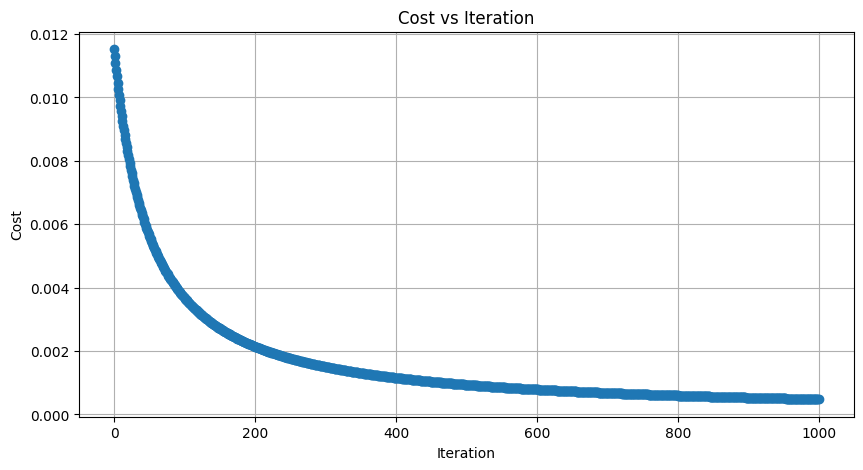

In [74]:
import matplotlib.pyplot as plt
# Unzip the x variable into two lists for plotting
iterations, costs = zip(*x)

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(iterations, costs, marker='o')
plt.title('Cost vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid()
plt.show()


##  Neural Networks in a Nutshell:  A Summary of Key Concepts

Towards the end of the lecture, the sources provide a concise summary of the fundamental concepts explored throughout the tutorial, reinforcing your understanding of neural networks and their training process.

Here's a breakdown of the key takeaways:

**Neural Networks as Mathematical Expressions**

At their core, neural networks are essentially mathematical expressions, often quite complex ones. These expressions take both data and network parameters (weights and biases) as input. In the case of multi-layer perceptrons (MLPs), these expressions involve interconnected layers of neurons, each performing weighted sums of their inputs followed by the application of a non-linear activation function.

**The Loss Function: Measuring Performance**

To assess the performance of a neural network, we employ a loss function. The loss function quantifies the discrepancy between the network's predictions and the desired targets. The goal of training is to minimize this loss, guiding the network towards making accurate predictions. The sources used a mean squared error loss for its simplicity, but other loss functions, like cross-entropy loss, are commonly used in practice.

**Backpropagation and Gradient Descent: The Optimization Engine**

Backpropagation, a cornerstone of neural network training, is an algorithm that efficiently computes the gradients of the loss function with respect to all the network's parameters. These gradients reveal how each parameter influences the loss.  Gradient descent then leverages this information to iteratively update the parameters, nudging them in a direction that reduces the loss.

**Iterative Training Process: A Cycle of Improvement**

The training process is iterative, involving the following steps:

1. **Forward Pass:** Input data is fed through the network to generate predictions.
2. **Loss Calculation:** The loss function quantifies the error between predictions and targets.
3. **Backward Pass:** Backpropagation calculates gradients of the loss with respect to parameters.
4. **Parameter Update:** Parameters are adjusted based on gradients using gradient descent, reducing the loss.

This cycle is repeated numerous times, with the network progressively refining its predictions and minimizing the loss.

**Power and Scalability of Neural Networks**

Even though the examples in the sources used a relatively small network with 41 parameters, neural networks can scale to immense sizes with billions or even trillions of parameters. This ability to scale, combined with the iterative training process guided by backpropagation and gradient descent, empowers neural networks to tackle incredibly complex tasks, such as language modeling with GPT-3.

**Emergent Properties: Unveiling Hidden Patterns**

When trained on large datasets, neural networks often exhibit remarkable emergent properties. For instance, a language model trained on a massive text corpus can generate coherent and contextually relevant text, demonstrating an ability to capture intricate patterns in language. These emergent properties underscore the power and potential of neural networks across diverse domains.

**Core Principles Across Libraries**

The foundational principles of neural networks, including backpropagation and gradient descent, are consistent across various deep learning libraries, including the production-grade PyTorch. The sources highlight the similarities between `micrograd` and PyTorch, demonstrating how the core concepts translate to real-world implementations. 

This summary, provided towards the end of the lecture, encapsulates the essential concepts explored throughout the tutorial. It serves as a concise reminder of how neural networks function, how they are trained, and the immense power they hold in addressing complex problems. 
